## Import libraries


In [1]:
from fastai.vision.all import *
from duckduckgo_search import DDGS
import time

### Create car model

In [2]:
car_models= "G-wagon", "911", "RS7"
path= Path("car_models")

### add extra library

In [3]:
#%pip uninstall -y duckduckgo_search
#%pip install ddgs
#%pip install -U duckduckgo_search

## Now search some car photos


In [4]:

def search_images(term, max_images=30):
    print(f"Searching for {term}...")
    with DDGS() as ddgs:
        # Yeni kütüphane sürümüyle uyumlu arama
        results = ddgs.images(keywords=term, max_results=max_images)
        return L(results).itemgot('image')


## Create folder and download images


In [5]:

if not path.exists():
    path.mkdir()

for o in car_models:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    
    #check whether there are images in the folder or not 
    if len(get_image_files(dest)) > 0:
        print(f"Skipping {o}, already downloaded...")
        continue

    try:
        # Search
        urls = search_images(f"{o} photo")
        
        # Download
        download_images(dest, urls=urls)
        
        print(f"{o} downloaded. Sleeping for 10s...")
        time.sleep(10)
        
    except Exception as e:
        print(f"Error downloading {o}: {e}")
        print("Waiting 20s before retry...")
        time.sleep(20)

print("Process finished.")

# Cleaning and Checking for error
img = get_image_files(path)
broken_photos = verify_images(img)
broken_photos.map(Path.unlink)
print(f"Cleaning done. Total {len(img) - len(broken_photos)} images ready.")

Skipping G-wagon, already downloaded...
Skipping 911, already downloaded...
Skipping RS7, already downloaded...
Process finished.
Cleaning done. Total 84 images ready.


### General information about folders

In [6]:
# 1. Path
print(f"Searching on: {path}")

# 2. what is inside of that folder
if path.exists():
    print("Contents of the folder:", path.ls())
else:
    print("HATA: Böyle bir klasör hiç yok!")

# 3. How many images are there
files = get_image_files(path)
print(f"Total image that found: {len(files)}")

Searching on: car_models
Contents of the folder: [Path('car_models/RS7'), Path('car_models/G-wagon'), Path('car_models/911')]
Total image that found: 84


## Create Datablock


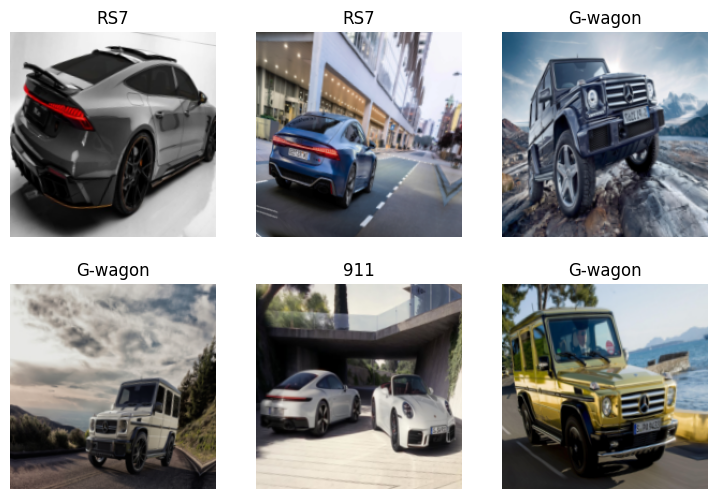

In [7]:
#standart functions block
cars = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    get_y =parent_label,
    splitter =RandomSplitter(valid_pct=0.2, seed=42),
    item_tfms=Resize(192, method='squish'), 
    batch_tfms=aug_transforms()   
    )


dls = cars.dataloaders(path, bs=32)
dls.show_batch(max_n=6)

## Train AI 

In [8]:
# We gonna use resnet18 beacuse it is light and fast
dls = cars.dataloaders(path, bs=32)
learn = vision_learner(dls,resnet18,metrics = error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,2.082064,1.159065,0.437500,00:06


epoch,train_loss,valid_loss,error_rate,time
0,1.095397,0.963834,0.312500,00:07
1,1.063802,0.839537,0.312500,00:07
2,0.822652,0.852947,0.250000,00:08


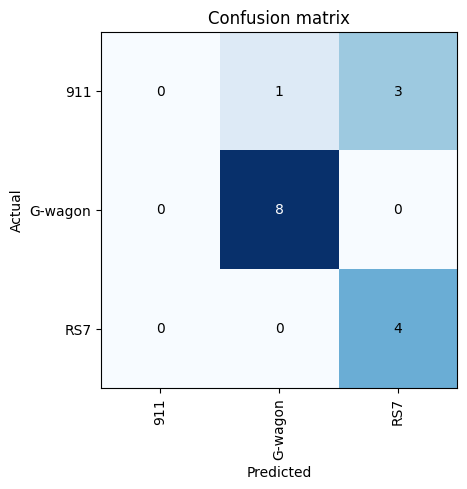

In [9]:

# Interpreter
interp = ClassificationInterpretation.from_learner(learn)

# Error Matrix
interp.plot_confusion_matrix()

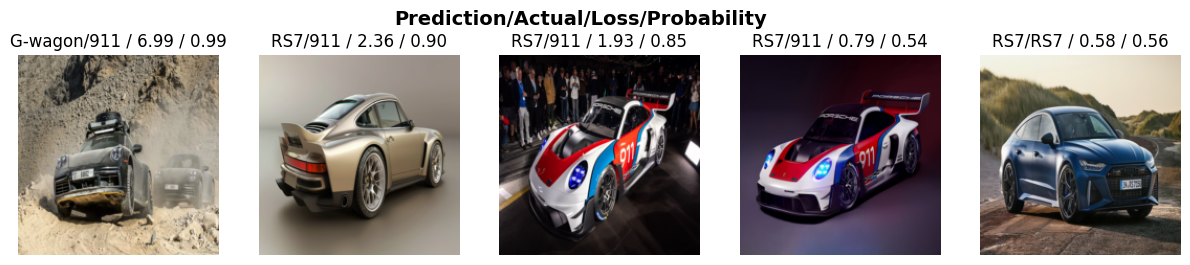

In [10]:
# show biggets 5 error 
interp.plot_top_losses(5, nrows=1)


In [11]:
# test via gradio website 
# add gradio library
#!pip install gradio

In [12]:
# We add a library to check and correct errors
# %pip install ipywidgets

### Train Model

In [13]:
# We are educating our model
# We don't upload from the file, we recreate it.
dls = cars.dataloaders(path, bs=32)
learn = vision_learner(dls,resnet18,metrics = error_rate)
learn.fine_tune(5)

epoch,train_loss,valid_loss,error_rate,time
0,1.911897,1.131005,0.437500,00:07


epoch,train_loss,valid_loss,error_rate,time
0,1.683550,0.855550,0.312500,00:07
1,1.235784,0.801249,0.312500,00:08
2,0.987590,0.959666,0.250000,00:07
3,0.782324,0.956118,0.187500,00:08
4,0.655361,0.907364,0.187500,00:07


### Export Model

In [14]:
# If you feel ready! you can export now, if not go to testing and cleaning part
#learn.export("updated_car_model.pkl")

### Testing Part (if you need)


In [15]:
### If you wish you can test model on locally

In [16]:

from fastai.vision.all import *
import gradio as gr

# upload model
learn = load_learner('car_model_v2.pkl')

# get categories 
categories = learn.dls.vocab

# predict function
def classify_image(img):
    pred, idx, probs = learn.predict(img)
    # Gradio bizden sözlük {Kategori: Olasılık} formatı ister
    return dict(zip(categories, map(float, probs)))

# interface
image = gr.Image()
label = gr.Label()
examples = ['g_wagon.jpg', '911.jpg'] # Eğer klasöründe örnek resim varsa buraya ismini yaz

intf = gr.Interface(fn=classify_image, inputs=image, outputs=label, examples=examples)
intf.launch(inline=False)

/opt/anaconda3/envs/fastai_env/lib/python3.10/site-packages/fastai/learner.py:455: UserWarning: load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.
If you only need to load model weights and optimizer state, use the safe `Learner.load` instead.
  warn("load_learner` uses Python's insecure pickle module, which can execute malicious arbitrary code when loading. Only load files you trust.\nIf you only need to load model weights and optimizer state, use the safe `Learner.load` instead.")


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


### Cleaning Part (if you need uncomment the codes)

In [ ]:
from fastai.vision.all import *
from fastai.vision.widgets import *

# We don't upload from the file, we recreate it.
dls = cars.dataloaders(path, bs=32)
learn = vision_learner(dls, resnet18, metrics=error_rate)

# little warm-up lap
learn.fine_tune(2)

# start cleaning 
cleaner = ImageClassifierCleaner(learn)
cleaner

epoch,train_loss,valid_loss,error_rate,time


In [ ]:
# Delete form disk hwich is labeled as Delete
for idx in cleaner.delete():
    cleaner.fns[idx].unlink()

# Move images if you do category cahnges
for idx,cat in cleaner.change():
    shutil.move(str(cleaner.fns[idx]), path/cat)

print("Process is done! Marked images deleted or moved.")

In [ ]:
# if you do clenaning dont forget to retrain and export 

dls = cars.dataloaders(path, bs=32)
learn = vision_learner(dls, resnet18, metrics=error_rate)

learn.fine_tune(5)
#learn.export("car_model_v2.pkl")